In [7]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [8]:
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000
EPS = 0.1

In [9]:
class Bandit(ABC):

    @abstractmethod
    def __init__(self, reward):
        self.reward = reward

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot_learning_process(self): 
        pass

    @abstractmethod
    def report(self):
        pass

# Epsilon Greedy

In [10]:
class EpsilonGreedy(Bandit):
    """
    An implementation of the Epsilon Greedy algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, reward):
        """
        Constructor for the EpsilonGreedy class.
        """
        self.reward = reward
        self.reward_estimate = 0
        self.N = 0
        self.rewards = []  #Adding an attribute to store rewards
    
    def __repr__(self):
        """
        String representation of the class.
        """
        return f'A Bandit with {self.reward} Reward'
    
    def pull(self):
        """
        Pulls the arm of the bandit and generate a random reward.
        """
        x = np.random.randn() + self.reward
        self.rewards.append(x)  # Store the reward
        return x
    
    def update(self, x):
        """
        Updates the reward estimate based on the current reward obtained.
        """
        self.N += 1
        self.reward_estimate = (1 - 1.0/self.N) * self.reward_estimate + 1.0/ self.N * x

    def experiment(self, bandit_rewards, t, N):
        """
        Runs the Epsilon Greedy algorithm on a set of bandits.
        """
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        num_times_explored = 0
        num_times_exploited = 0
        num_optimal = 0
        optimal_j = np.argmax([b.reward for b in bandits])
        print(f'optimal bandit index: {optimal_j}')
        
        # empty array to later add the rewards for inference plots
        eg_rewards = np.empty(N)
        eg_selected_bandit = []
        eps = 1/t

        for i in range(N):
            #generating a random number 
            p = np.random.random() 
            
            # if the random number is smaller than eps we explore a random bandit
            if p < eps:  
                num_times_explored += 1
                j = np.random.choice(len(bandits)) 
            else:
                # if the random number is bigger than eps we explore the bandit with the highest current reward
                num_times_exploited += 1
                j = np.argmax([b.reward_estimate for b in bandits])
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()
            
            # increases N by 1 and calculates the estimate of the reward
            bandits[j].update(x) 
            
            # if j is the actual optimal bandit, the optimal bandit count increments by 1
            if j == optimal_j:
                num_optimal += 1
            
            # add the selected bandit to the list of selected bandits
            eg_selected_bandit.append(j)
            
            # add the reward to the data
            eg_rewards[i] = x
            
            # increase t, i.e., decrease the probability of choosing suboptimal (random) bandit
            t += 1
            eps = 1/t
        
        estimated_avg_rewards=[round(b.reward_estimate, 3) for b in bandits]
        print(f'Estimated average reward where epsilon= {eps}:---{estimated_avg_rewards}')
        
        all_bandits = pd.DataFrame({"Bandit" : eg_selected_bandit, "Reward" : eg_rewards, "Algorithm" : "Epsilon Greedy"})
        file_path = "EpsilonGreedy_All.csv"
        all_bandits.to_csv(file_path, index=False)
        
        return bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal
    
    def plot_learning_process(self, bandit_rewards, eg_rewards, N):
        """
        Plots the win rate and optimal win rate against the number of trials.
        """        
        cumulative_rewards = np.cumsum(eg_rewards)
        win_rates = cumulative_rewards / (np.arange(N) + 1)
        
        plt.figure(figsize=(10, 8))
        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(N)*np.max(bandit_rewards), label='Optimal Win Rate')
        plt.legend()
        plt.title("Win Rate Convergence Epsilon-Greedy")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def report(self, bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal, N):
        """
        Creates a report with statistics such as mean estimates, total reward earned,
        and the number of times a bandit was explored or exploited, and saves the output in a csv file.
        """
        df = pd.DataFrame()
        for i, b in enumerate(bandits):
            print(f"Bandit {i} Mean Estimate: {b.reward_estimate :.4f}")
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.reward_estimate for b in bandits]
            df["Algorithm"] = "EpsilonGreedy"
    
        print(f"\nTotal Reward Earned: {eg_rewards.sum()}")
        print(f"Average Reward: {np.mean(eg_rewards)}")
        print(f"Overall Win Rate: {eg_rewards.sum() / N :.4f}\n")
        print(f"# of explored: {num_times_explored}")
        print(f"# of exploited: {num_times_exploited}")
        print(f"# of times selected the optimal bandit: {num_optimal}")
        
        file_path = "EpsilonGreedy_Last.csv"
        df.to_csv(file_path, index=False)
        
        return df

In [11]:
EG = EpsilonGreedy(Bandit)

In [12]:
bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal = EG.experiment(BANDIT_REWARD, 10, N=NUMBER_OF_TRIALS) # t=10 -> eps = 1/t = 0.1

optimal bandit index: 3
Estimated average reward where epsilon= 4.9975012493753125e-05:---[0.453, 2.645, 0, 4.005]


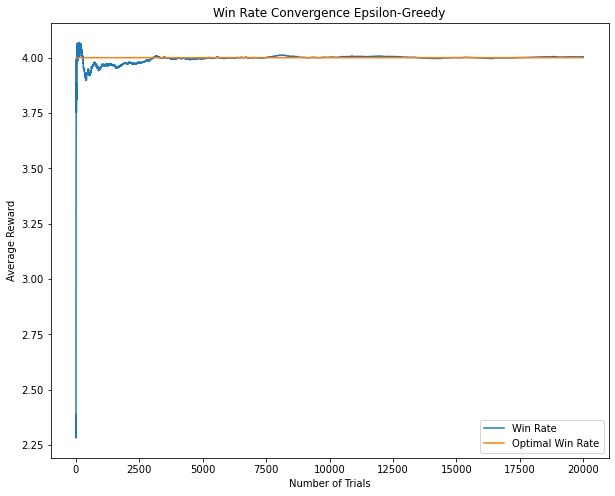

In [13]:
EG.plot_learning_process(BANDIT_REWARD, eg_rewards, N=NUMBER_OF_TRIALS)

In [14]:
df = EG.report(bandits, eg_rewards, num_times_explored, num_times_exploited, num_optimal, N=NUMBER_OF_TRIALS)

Bandit 0 Mean Estimate: 0.4526
Bandit 1 Mean Estimate: 2.6445
Bandit 2 Mean Estimate: 0.0000
Bandit 3 Mean Estimate: 4.0047

Total Reward Earned: 80086.55572232183
Average Reward: 4.004327786116091
Overall Win Rate: 4.0043

# of explored: 9
# of exploited: 19991
# of times selected the optimal bandit: 19996


# Thompson Sampling

In [15]:
class ThompsonSampling(Bandit):
    """
    An implementation of the Thompson Sampling algorithm for multi-armed bandit problems.

    Inherits from the Bandit class.
    """
    
    def __init__(self, true_mean):
        """
        Constructor for the ThompsonSampling class.
        """
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.sum_x = 0
        self.rewards = []  #Adding an attribute to store rewards
        
    def __repr__(self):
        """
        String representation of the class.
        """
        return f"A Bandit with {self.true_mean} Win Rate"

    def pull(self):
        """
        Samples a reward from the bandit using its true mean.
        """
        x = np.random.randn() / np.sqrt(self.tau) + self.true_mean
        self.rewards.append(x)  # Store the reward
        return x

    def sample(self):
        """
        Samples a reward from the bandit using its posterior mean.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Updates the bandit's posterior mean and precision using the reward received.
        """
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    
    def experiment(self, bandit_rewards, N):
        """
        Runs the Thompson Sampling algorithm on a set of bandits.
        """
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        sample_points = [100, 1000, 3000, 5000, 10000, 19999]
        
        # empty array to later add the rewards for inference plots
        t_rewards = np.empty(N)
        t_selected_bandit = []
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits]) #taking the highest mean position
            
            # make some plots
            if i in sample_points:
                self.plot_bandit_distributions(bandits, i)
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()

            # increases N by 1, updates lambda and calculates the estimate of the m
            bandits[j].update(x)
            
            # add the reward to the data
            t_rewards[i] = x
            
            # Add the selected bandit to the list
            t_selected_bandit.append(j)
        
        all_bandits = pd.DataFrame({"Bandit" : t_selected_bandit, "Reward" : t_rewards, "Algorithm" : "Thompson Sampling"})
        file_path = "ThompsonSampling_All.csv"
        all_bandits.to_csv(file_path, index=False)

        return bandits, t_rewards
    
    def plot_learning_process(self, bandit_rewards, t_rewards, N):
        """
        Plots the win rate and optimal win rate against the number of trials.
        """
        cumulative_rewards = np.cumsum(t_rewards)
        win_rates = cumulative_rewards / (np.arange(N) + 1)
        
        plt.figure(figsize=(10, 8))
        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(N)*np.max(bandit_rewards), label='Optimal Win Rate')
        plt.legend()
        plt.title("Win Rate Convergence Thompson Sampling")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def plot_bandit_distributions(self, bandits, trial):
        """
        Plots the distribution of each bandit after a given number of trials.
        """
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title(f"Bandit distributions after {trial} trials")
        plt.legend()
        plt.show()
        
    def report(self, bandits, t_rewards, N):
        """
        Creates a report with statistics such as total reward earned, average reward,
        and the overall win rate, and saves the output in a csv file.
        """
        df = pd.DataFrame()
        for b in bandits:
            df["Bandit"] = [b for b in bandits]
            df["Reward"] = [b.m for b in bandits]
            df["Algorithm"] = "ThompsonSampling"
        
        print(f"Total Reward Earned: {t_rewards.sum()}")
        print(f"Average Reward: {np.mean(t_rewards)}")
        print(f"Overall Win Rate: {t_rewards.sum() / N}")
        print(f"Number of times selected each bandit: {[b.N for b in bandits]}")
        
        file_path = "ThompsonSampling_Last.csv"
        df.to_csv(file_path, index=False)
        
        return df

In [16]:
TS = ThompsonSampling(Bandit)

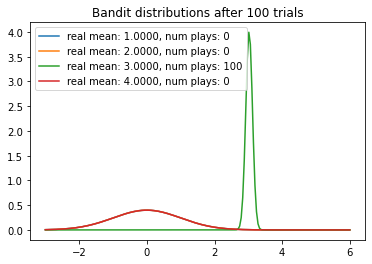

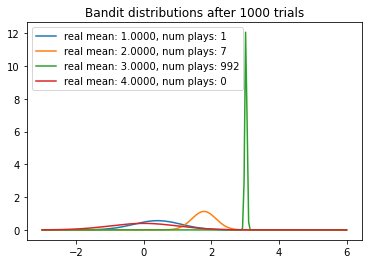

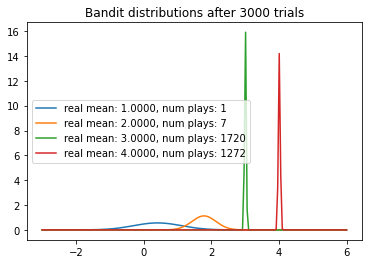

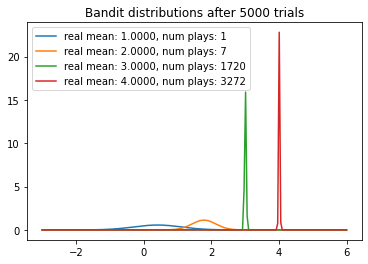

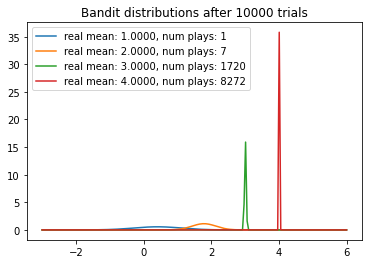

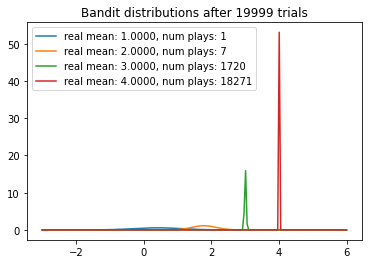

In [17]:
bandits, t_rewards = TS.experiment(BANDIT_REWARD, N=NUMBER_OF_TRIALS)

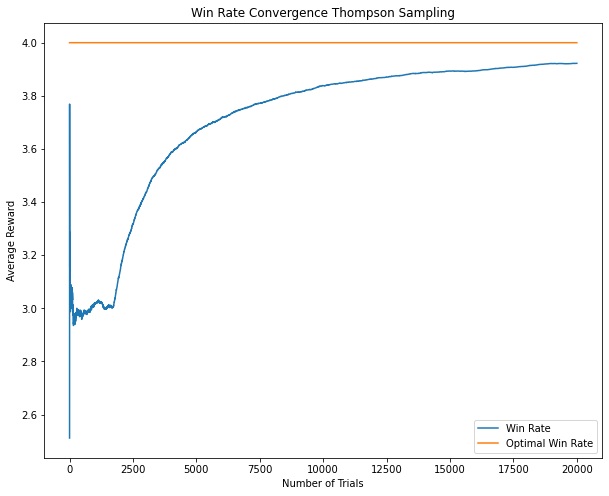

In [18]:
TS.plot_learning_process(BANDIT_REWARD, t_rewards, N=NUMBER_OF_TRIALS)

In [19]:
df = TS.report(bandits, t_rewards, N=NUMBER_OF_TRIALS)

Total Reward Earned: 78445.48004955958
Average Reward: 3.9222740024779794
Overall Win Rate: 3.9222740024779794
Number of times selected each bandit: [1, 7, 1720, 18272]


# Visualization

In [20]:
class Visualization:
    def plot1(self, bandits, trial, eg_rewards, t_rewards):
        """
        Visualize the performance of each bandit: linear and log.
        """
        x = np.arange(1, trial + 1)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        
        for b in bandits:
            cumulative_eg_rewards = np.cumsum(eg_rewards[bandits.index(b)])
            average_eg_rewards = cumulative_eg_rewards / x
            plt.plot(x, average_eg_rewards, label=f"Epsilon-Greedy Bandit {bandits.index(b)}")
        
        plt.title("Performance of Each Bandit (Linear Scale) - Epsilon-Greedy")
        plt.xlabel("Trial")
        plt.ylabel("Average Reward")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        
        for b in bandits:
            cumulative_t_rewards = np.cumsum(t_rewards[bandits.index(b)]) 
            average_t_rewards = cumulative_t_rewards / x
            plt.plot(x, average_t_rewards, label=f"Thompson Sampling Bandit {bandits.index(b)}")
        
        plt.title("Performance of Each Bandit (Log Scale) - Thompson Sampling")
        plt.xlabel("Trial")
        plt.ylabel("Average Reward")
        plt.yscale('log')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        
    def plot2(self, bandits, trial, eg_rewards, t_rewards):
        """
        Compare E-greedy and Thompson Sampling cumulative rewards and cumulative regrets.
        """
        x = np.arange(1, trial + 1)
    
        cumulative_eg_rewards = np.cumsum(eg_rewards)
        cumulative_t_rewards = np.cumsum(t_rewards)
    
        cumulative_regrets_eg = np.cumsum(np.max([b.reward for b in bandits]) - eg_rewards)
        cumulative_regrets_t = np.cumsum(np.max([b.true_mean for b in bandits]) - t_rewards)
    
        plt.figure(figsize=(12, 6))
    
        plt.subplot(1, 2, 1)
        plt.plot(x, cumulative_eg_rewards, label="Epsilon-Greedy")
        plt.plot(x, cumulative_t_rewards, label="Thompson Sampling")
        plt.title("Cumulative Rewards Comparison")
        plt.xlabel("Trial")
        plt.ylabel("Cumulative Reward")
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(x, cumulative_regrets_eg, label="Epsilon-Greedy")
        plt.plot(x, cumulative_regrets_t, label="Thompson Sampling")
        plt.title("Cumulative Regrets Comparison")
        plt.xlabel("Trial")
        plt.ylabel("Cumulative Regret")
        plt.legend()
    
        plt.tight_layout()
        plt.show()


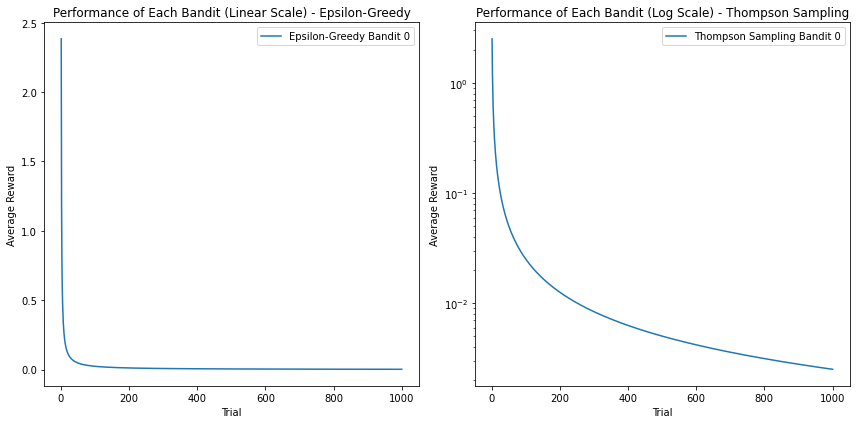

In [21]:
visualizer = Visualization()
bandits = [...]  # Your bandit data
trial = 1000    

visualizer.plot1(bandits, trial, eg_rewards, t_rewards)

# Comparison

In [22]:
def comparison(epsilon_rewards, thompson_rewards):
    """
    Plot and compare the performance of two algorithms, Epsilon Greedy and Thompson Sampling,
    based on their cumulative rewards and mean reward per trial.
    """
    # Plot cumulative rewards for each algorithm
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_rewards, label='Epsilon Greedy', alpha=0.75)
    plt.plot(thompson_rewards, label='Thompson Sampling', alpha=0.75)
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Trial', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)
    plt.legend()
    plt.show()

    # Plot mean reward per round for each algorithm
    epsilon_mean = [sum(epsilon_rewards[:i+1])/(i+1) for i in range(len(epsilon_rewards))]
    thompson_mean = [sum(thompson_rewards[:i+1])/(i+1) for i in range(len(thompson_rewards))]
    plt.figure(figsize=(10, 8))
    plt.plot(epsilon_mean, label='Epsilon Greedy')
    plt.plot(thompson_mean, label='Thompson Sampling')
    plt.title('Comparison of Epsilon Greedy and Thompson Sampling', fontsize=20)
    plt.xlabel('Trial', fontsize=14)
    plt.ylabel('Mean Reward', fontsize=14)
    plt.legend()
    plt.show()

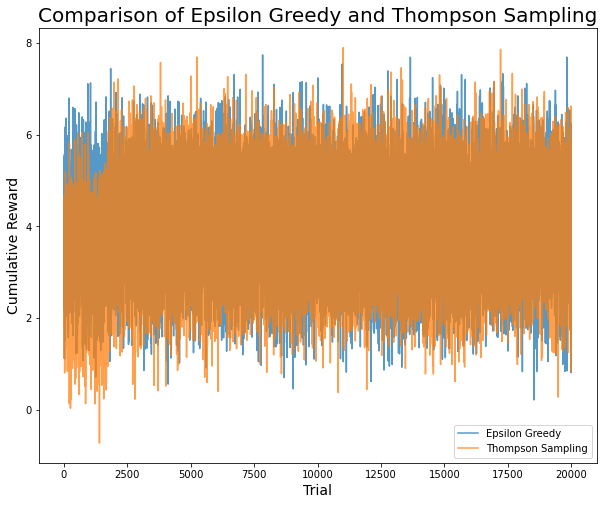

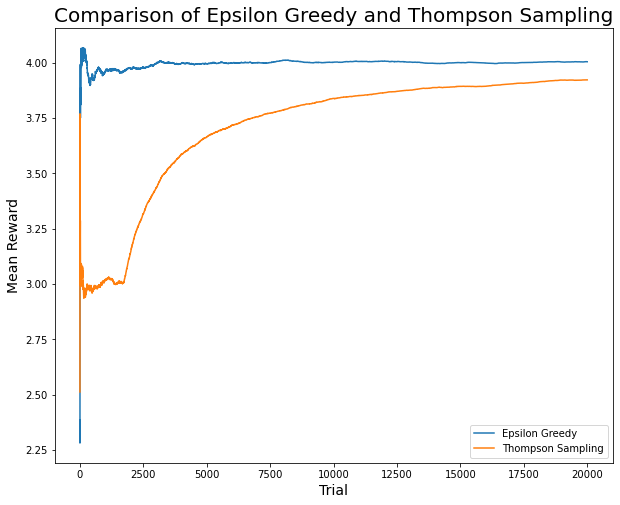

In [23]:
comparison(eg_rewards, t_rewards)

When choosing between Epsilon Greedy and Thompson Sampling, it depends on the problem and what you want to balance between trying new options and sticking with what you know works. Epsilon Greedy is simpler and easier to use, good when rewards are consistent and you adjust how often you explore. Thompson Sampling is more complicated, but it handles uncertain rewards and works better when rewards vary a lot or when you're not sure how good the options are.

So, it's a good idea to test both on the specific problem and see which one works better based on your needs.